### Offline Augmentation
1. 특정 라벨들을 포함하는 증강할 데이터 셋 생성
2. 생성한 데이터 셋으로 Augmentation 기법을 적용하여 새로 저장

- 아래의 학습데이터 경로와 저장할 데이터 경로만 잘 설정하시고 쭉 실행시키시면 아마 될겁니다..

In [1]:
import os
import json
import shutil
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from mmseg.datasets import build_dataset
from glob import glob
plt.rcParams['axes.grid'] = False

In [2]:
####################### 학습 데이터 경로 #######################
train_data_path = '/opt/ml/input/data/stratified_kfold/cv_train_1.json'

####################### CoCo format으로 변환한 데이터 경로 #########################
#######################  저장되는 데이터 경로입니다. ##########################
save_path = '/opt/ml/input/mmseg'

####################### 복사할 데이터 경로 #######################
################    이부분은 안바꾸셔도 됩니당    ################
copy_path = '/opt/ml/input/aug_list/'

####################### 증강에서 제외할 라벨 #######################
ignore_label = [2,6,8]

In [3]:
classes = ['Background', 'General trash', 'Paper', 'Paper pack', 'Metal', 'Glass', 'Plastic','Styrofoam', 'Plastic bag', 'Battery', 'Clothing']
palette = [
    [0, 0, 0],
    [192, 0, 128], [0, 128, 192], [0, 128, 64],
    [128, 0, 0], [64, 0, 128], [64, 0, 192],
    [192, 128, 64], [192, 192, 128], [64, 64, 128], [128, 0, 192],[128,64,64]
    ]
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)

In [4]:
def make_aug_list(train_data_path, save_path,copy_path,ignore_label=None):
    with open(train_data_path) as f:
        train = json.load(f)

    add_list = []
    for i in range(len(train['annotations'])):
        sample = train['annotations'][i]
        if ignore_label is not None:
            if sample['category_id'] in ignore_label:
                continue

        image_id = str(sample['image_id'])
        while len(image_id) != 4:
            image_id = '0' + image_id
        add_list.append(image_id)
    # add_list = []
    # n=0
    # for i in range(len(train['images'])):
    #     tmp_id=train['images'][i]['id']
    #     checked_ignore_label=False
    #     while train['annotations'][n]['image_id']==tmp_id:
    #         if train['annotations'][n]['category_id'] in ignore_label:
    #             checked_ignore_label=True
    #         n+=1
    #         if n>=len(train['annotations']):
    #             break
    #     if not checked_ignore_label:
    #         image_id = str(tmp_id)
    #         while len(image_id) != 4:
    #             image_id = '0' + image_id
    #         add_list.append(image_id)

    add_list = set(add_list)
    
    image_paths = glob(os.path.join(save_path,'images/train','*.jpg'))
    annotation_paths = glob(os.path.join(save_path,'annotations/train','*.png'))
    image_paths.sort()
    annotation_paths.sort()
    os.makedirs(copy_path, exist_ok=True)
    os.makedirs(copy_path + 'images/train', exist_ok=True)
    os.makedirs(copy_path + 'annotations/train', exist_ok=True)

    for i in range(len(image_paths)):
        image_path = image_paths[i]
        image_name = image_path.split('/')[-1].split('.')[0]
        mask_path = annotation_paths[i]

        if image_name not in (add_list):
            continue

        shutil.copyfile(image_path , os.path.join(copy_path,'images/train',image_name+'.jpg'))
        shutil.copyfile(mask_path , os.path.join(copy_path,'annotations/train',image_name+'.png'))
        
        
def label_mask(mask):
    mask = mask[:,:,-1]
    label = np.zeros((mask.shape[0], mask.shape[1], 3)).astype(np.uint8)
    for i in range(1, 11):
        label[mask == i] = palette[i]
    return label

def show_data(file_path,image_id):
    mask = cv2.imread(os.path.join(file_path,'annotations/train/', image_id +'.png'))
    image = cv2.imread(os.path.join(file_path,'images/train/', image_id +'.jpg'))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image)
    ax[0].axis('off')
    ax[1].imshow(label_mask(mask))
    ax[1].axis('off')
    plt.show()

def check_data(file_path):
    image_paths = glob(os.path.join(file_path,'images/train','*.jpg'))
    annotation_paths = glob(os.path.join(file_path,'annotations/train','*.png'))
    print(f'train_image_count : {len(image_paths)}')
    print(f'train_annotation_count : {len(annotation_paths)}')

def convert(datasets):
    sample = datasets
    img = sample['img'].data.cpu().numpy()
    img = np.einsum("chw -> hwc", img)
    img =  img * sample['img_metas'].data['img_norm_cfg']['std'] + sample['img_metas'].data['img_norm_cfg']['mean']
    img = img.astype(np.uint8)
    
    gt_seg_map = sample['gt_semantic_seg'].data.cpu().numpy().squeeze()
    label = np.zeros((gt_seg_map.shape[0], gt_seg_map.shape[1], 3)).astype(np.uint8)
    for i in range(1, 11):
        label[gt_seg_map == i] = palette[i]
    mask = np.zeros((gt_seg_map.shape[0], gt_seg_map.shape[1], 3)).astype(np.uint8)
    for i in range(3):
        mask[:,:,i] = gt_seg_map

    return img,mask,label

def Mosaic_augmentation(save_path):
    check_data(save_path)

    for i in range(len(datasets)):
            image_name = datasets[i]['img_metas'].data['ori_filename'].split('.')[0]
            new_image_name = '2' + image_name

            img,mask,label = convert(datasets[i])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            cv2.imwrite(os.path.join(save_path,'images/train',new_image_name+'.jpg'),img)
            cv2.imwrite(os.path.join(save_path,'annotations/train',new_image_name+'.png'),mask[:512,:512,0])
            
    check_data(save_path)

특정 라벨들을 포함하는 증강할 데이터 셋 생성

train_image_count : 1721
train_annotation_count : 1721


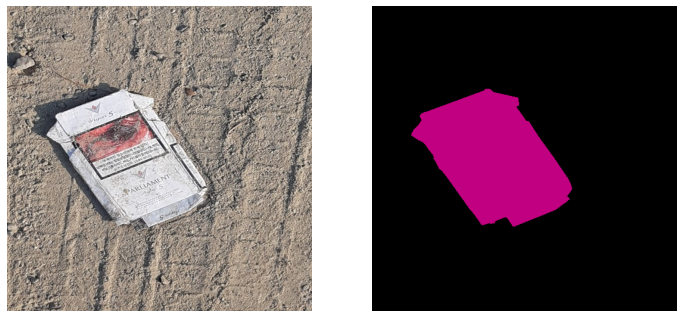

In [5]:
# 증강할 데이터셋 생성
make_aug_list(train_data_path,save_path,copy_path,ignore_label)

### 복사한 이미지 개수
check_data(copy_path)

### 복사한 이미지 확인
show_data(copy_path,'0006')

### Config File
- 기존의 Config File과 같은 형식입니다.

In [6]:
###################### modified root ######################
data_root = copy_path
img_root = data_root + 'images/train'
ann_root = data_root + 'annotations/train'
###################### modified root ######################


############################## Augmentation ###############################
train_pipeline = [
    dict(type='RandomFlip', prob=1),
    dict(type='RandomMosaic', prob=1, img_scale=(512, 512),center_ratio_range=(1.0,1.0)),
    dict(type='Resize', img_scale=(512, 512)),
    dict(type='Normalize', **img_norm_cfg),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]
############################### Augmentation ###############################


dataset_type = 'CustomDataset'
data = dict(
    samples_per_gpu=1,
    workers_per_gpu=4,
    train=dict(
        type = 'MultiImageMixDataset',
        dataset = dict(
            type=dataset_type,
            classes=classes,
            palette=palette,
            data_root=data_root,
            img_dir=img_root,
            ann_dir=ann_root,
            pipeline=[dict(type='LoadImageFromFile'),
                      dict(type='LoadAnnotations')
            ]),
            pipeline=train_pipeline),)

In [7]:
############################### Data Transform ###############################
datasets = build_dataset(data['train'])

2022-05-14 09:20:16,801 - mmseg - INFO - Loaded 1721 images


### Augmentation 미리보기

(-0.5, 511.5, 511.5, -0.5)

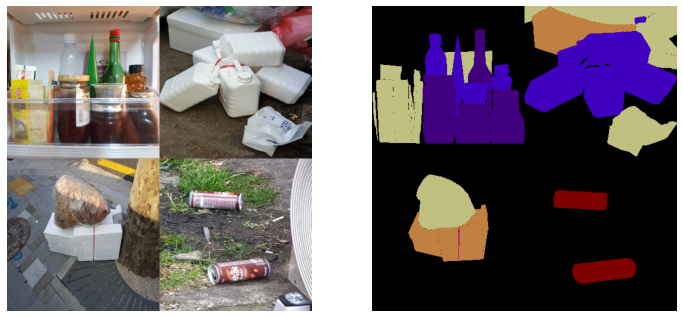

In [8]:
img,mask,label = convert(datasets[0])
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img)
ax[0].axis('off')
ax[1].imshow(label_mask(mask))
ax[1].axis('off')

### 이미지 추가

In [10]:
Mosaic_augmentation(save_path)

train_image_count : 2618
train_annotation_count : 2618
train_image_count : 4339
train_annotation_count : 4339


### 저장된 이미지 확인

###################### 원본 이미지 ######################


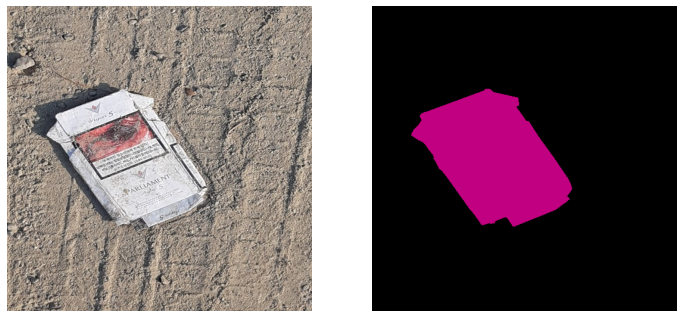

###################### 변환 이미지 ######################


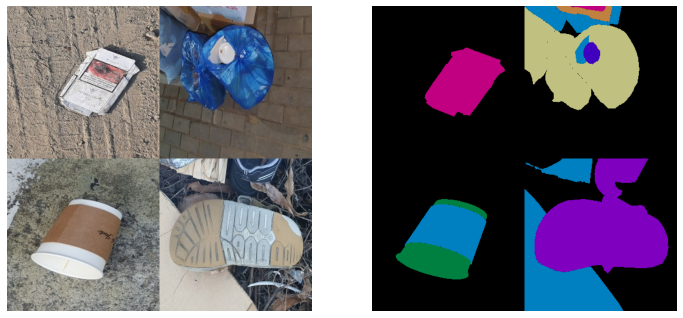

In [11]:
########### 보고 싶은 이미지 id ###########
or_image_id = '0006'
tf_image_id = '2' + or_image_id
print('###################### 원본 이미지 ######################')
show_data(save_path,or_image_id)
print('###################### 변환 이미지 ######################')
show_data(save_path,tf_image_id)